Text classification example.

References:
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

In [5]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


In [6]:
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


Text preprocessing and generation of text vector representations based on TF-IDF.
- `sublinear_tf` is set to `True` to use a logarithmic form for frequency.
- `min_df` is the minimum numbers of documents a word must be present in to be kept.
- `norm is set` to `l2`, to ensure all our feature vectors have a euclidian norm of 1.
- `ngram_range` is set to `(1, 2)` to indicate that we want to consider both unigrams and bigrams.
- `stop_words` is set to `"english"` to remove all common pronouns (`"a"`, `"the"`, ...) to reduce the number of noisy features.

In [10]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

CPU times: user 1.45 s, sys: 3.95 ms, total: 1.45 s
Wall time: 1.45 s


In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='latin-1', min_df=5, norm='l2', stop_words='english', ngram_range=(1, 2), sublinear_tf=True)
features = tfidf.fit_transform(text).toarray()
labels = df.category_id
features.shape

CPU times: user 2.01 s, sys: 280 ms, total: 2.29 s
Wall time: 2.14 s


(3595, 10850)

### Model selection

In [14]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 1min 1s, sys: 688 ms, total: 1min 2s
Wall time: 36.7 s


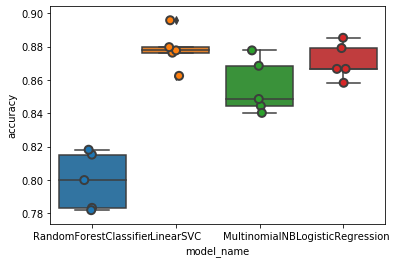

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [20]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.878444
LogisticRegression        0.871230
MultinomialNB             0.855929
RandomForestClassifier    0.799747
Name: accuracy, dtype: float64

Best model evaluation

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
    return cm

accuracy 0.8812131423757371
confusion matrix
 [[220  15   9  10   1]
 [ 16 212   6   5   3]
 [ 11   9 178   2  24]
 [  2   0   3 209   5]
 [  1   0  14   5 227]]
(row=expected, col=predicted)
CPU times: user 435 ms, sys: 144 ms, total: 579 ms
Wall time: 492 ms


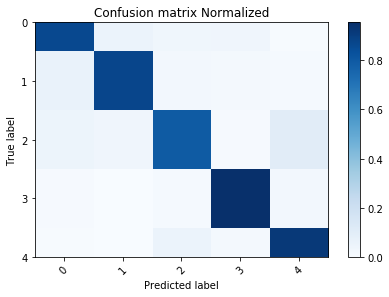

In [36]:
%%time

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = evaluate_prediction(y_pred, y_test)

In [38]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.88      0.86      0.87       255
                                                             Debt collection       0.90      0.88      0.89       242
                                                 Credit card or prepaid card       0.85      0.79      0.82       224
                                                                    Mortgage       0.90      0.95      0.93       219
                                                 Checking or savings account       0.87      0.92      0.90       247

                                                                    accuracy                           0.88      1187
                                                                   macro avg       0.88      0.88      0.88      1187
                                                      